In [15]:
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd

# ====================
# 1. Memuat Data dan Preprocessing
# ====================
processed_data = pd.read_pickle('../data/processed_data.pkl')  # Membaca file pickle berisi data yang sudah di-preprocessing
X_train = processed_data['X_train']  # Data fitur untuk pelatihan
X_test = processed_data['X_test']  # Data fitur untuk pengujian
y_train = processed_data['y_train']  # Target label untuk pelatihan
y_test = processed_data['y_test']  # Target label untuk pengujian

# Mengatasi nilai NaN
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Menyeimbangkan dataset menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# ====================
# 2. Decision Tree Classifier
# ====================
print("=== Decision Tree Classifier ===")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_sm, y_train_sm)
dt_pred = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print(classification_report(y_test, dt_pred))

# ====================
# 3. Random Forest Classifier
# ====================
print("\n=== Random Forest Classifier ===")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf_model.fit(X_train_sm, y_train_sm)
rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# ====================
# 4. Logistic Regression
# ====================
print("\n=== Logistic Regression ===")
lr_model = LogisticRegression(random_state=42, max_iter=200)
lr_model.fit(X_train_sm, y_train_sm)
lr_pred = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

# ====================
# 5. Gradient Boosting
# ====================
print("\n=== Gradient Boosting ===")
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_sm, y_train_sm)
gb_pred = gb_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))
print(classification_report(y_test, gb_pred))

# ====================
# 6. Hyperparameter Tuning (Random Forest)
# ====================
print("\n=== Hyperparameter Tuning with GridSearchCV (Random Forest) ===")
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                           param_grid=param_grid,
                           cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_sm, y_train_sm)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)
print("Best Model Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))

# ====================
# 7. Menyimpan Model Terbaik
# ====================
joblib.dump(best_model, '../models/stroke_model.pkl')
print("\nModel terbaik telah disimpan sebagai '../models/stroke_model.pkl'")


=== Decision Tree Classifier ===
Decision Tree Accuracy: 0.840122199592668
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       929
           1       0.11      0.28      0.16        53

    accuracy                           0.84       982
   macro avg       0.53      0.58      0.54       982
weighted avg       0.91      0.84      0.87       982


=== Random Forest Classifier ===
Random Forest Accuracy: 0.8289205702647657
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       929
           1       0.15      0.47      0.23        53

    accuracy                           0.83       982
   macro avg       0.56      0.66      0.57       982
weighted avg       0.92      0.83      0.87       982


=== Logistic Regression ===
Logistic Regression Accuracy: 0.7505091649694501
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       929
       

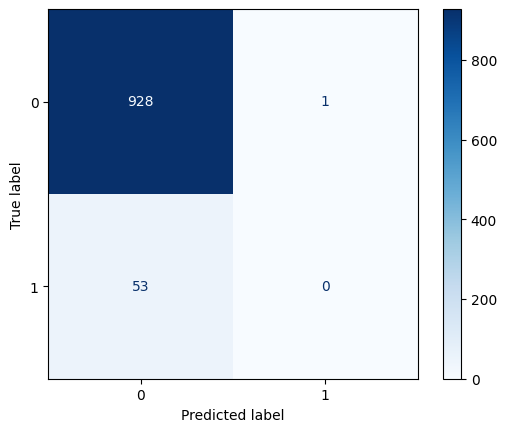

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi model
y_pred = best_model.predict(X_test)

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


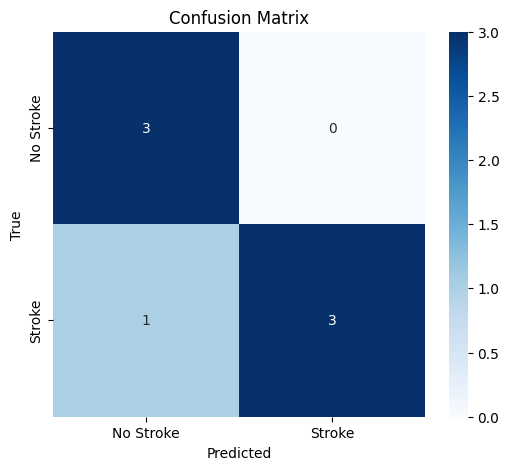

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Misal, y_test adalah label yang benar dan y_pred adalah prediksi model
y_test = [0, 1, 0, 1, 1, 0, 1]  # Contoh data
y_pred = [0, 1, 0, 0, 1, 0, 1]  # Contoh prediksi model

cm = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Contoh data
data = {'Age': [23, 45, 34, 50, 40],
        'BMI': [22.0, 28.5, 25.0, 30.0, 27.5]}

df = pd.DataFrame(data)

# Scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Membuat dataframe baru untuk menampilkan data sebelum dan sesudah scaling
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

# Menampilkan perbandingan
df_combined = pd.concat([df, scaled_df], axis=1)
df_combined.columns = ['Age', 'BMI', 'Scaled_Age', 'Scaled_BMI']
print(df_combined)


   Age   BMI  Scaled_Age  Scaled_BMI
0   23  22.0   -1.646894   -1.632479
1   45  28.5    0.705812    0.674285
2   34  25.0   -0.470541   -0.567819
3   50  30.0    1.240518    1.206615
4   40  27.5    0.171106    0.319398
